#### Imports


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('./stroke_data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# find and fill null values with averages (BMI has 201 null values)
avg = data['bmi'].mean()
data.bmi = data.bmi.fillna(avg)

#### Give numerical values to categorical variables

<table>
    <thead>
        <tr>
            <th colspan=2>work_type</th>
            <th colspan=2>gender</th>
            <th colspan=2>Residence_type</th>
            <th colspan=2>smoking_status</th>
            <th colspan=2>ever_married</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Private</td>
            <td>0</td>
            <td>Male</td>
            <td>0</td>
            <td>Urban</td>
            <td>0</td>
            <td>formerly smoked</td>
            <td>0</td>
            <td>Yes</td>
            <td>0</td>
        </tr>
        <tr>
            <td>Self-employed</td>
            <td>1</td>
            <td>Female</td>
            <td>1</td>
            <td>Rural</td>
            <td>1</td>
            <td>never smoked</td>
            <td>1</td>
            <td>No</td>
            <td>1</td>
        </tr>
        <tr>
            <td>Govt_job</td>
            <td>2</td>
            <td>smokes</td>
            <td>2</td>
        </tr>
        <tr>
            <td>children</td>
            <td>3</td>
            <td>Unknown</td>
            <td>3</td>
        </tr>
        <tr>
            <td>Never_worked</td>
            <td>4</td>
        </tr>
    </tbody>
</table>

In [4]:
data['work_type'] = data['work_type'].map({
    'Private': 0, 'Self-employed': 1,
    'Govt_job': 2, 'children': 3,
    'Never_worked': 4
})

data['gender'] = data['gender'].map({
    'Male': 0,
    'Female': 1
})

data['Residence_type'] = data['Residence_type'].map({
    'Urban': 0,
    'Rural': 1}
)

data['smoking_status'] = data['smoking_status'].map({
    'formerly smoked': 0,
    'never smoked': 1,
    'smokes': 2,
    'Unknown': 3
})

data['ever_married'] = data['ever_married'].map({
    'Yes': 0,
    'No': 1
})

# transform the 0 and 1 into values -1 and 1 in stroke column
data['stroke'] = data['stroke'].map({
    0: -1,
    1: 1
})

data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0.0,67.0,0,1,0,0,0,228.69,36.600000,0,1
1,51676,1.0,61.0,0,0,0,1,1,202.21,28.893237,1,1
2,31112,0.0,80.0,0,1,0,0,1,105.92,32.500000,1,1
3,60182,1.0,49.0,0,0,0,0,0,171.23,34.400000,2,1
4,1665,1.0,79.0,1,0,0,1,1,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1.0,80.0,1,0,0,0,0,83.75,28.893237,1,-1
5106,44873,1.0,81.0,0,0,0,1,0,125.20,40.000000,1,-1
5107,19723,1.0,35.0,0,0,0,1,1,82.99,30.600000,1,-1
5108,37544,0.0,51.0,0,0,0,0,1,166.29,25.600000,0,-1


In [5]:
# divide dataset into features and labels
# drop id because it's not necessary for analysis

X = data.iloc[:, 1:-1]
y = data.loc[:, 'stroke']

In [6]:
#replace null values again (1 in gender)
X.gender = (X.gender.fillna(1))

#### Heatmap

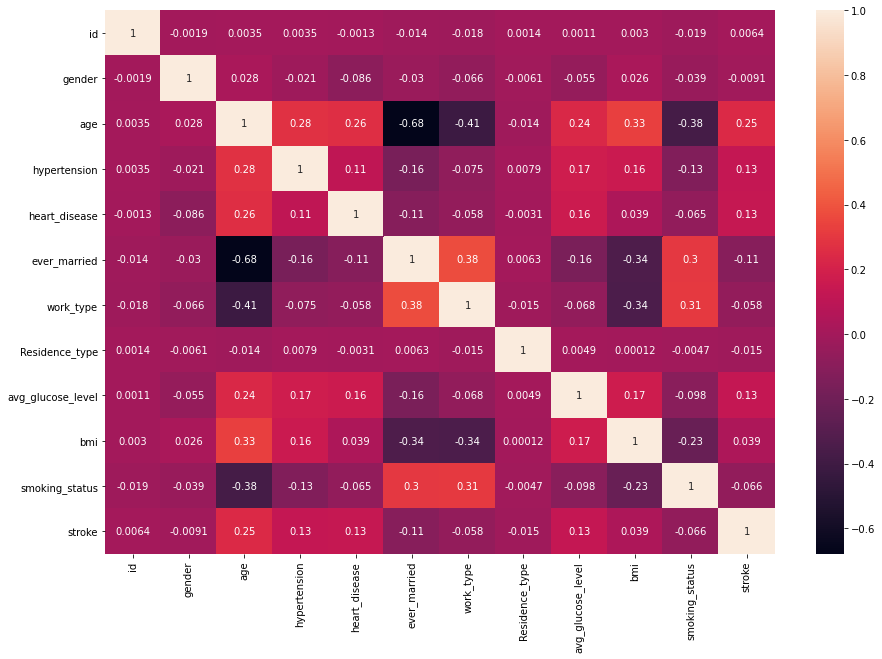

In [7]:
# heatmap - visualize correlation
plt.figure(figsize=(15, 10))
heatMap = data.corr()
sns.heatmap(heatMap, annot=True)
plt.show()

#### Split the dataset into train and test

In [8]:
#Standardize data using mean and standard deviation of column
scaler = StandardScaler()
s_X = pd.DataFrame(scaler.fit_transform(X.values))

#### Handle imbalanced data

In [9]:
#Using smote technique to handle the imbalanced data
smote = SMOTE()
s_X, y = smote.fit_resample(s_X, y)

#### Add a bias feature to X

In [10]:
X.insert(loc=len(X.columns), column='bias', value=1)
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bias
0,0.0,67.0,0,1,0,0,0,228.69,36.600000,0,1
1,1.0,61.0,0,0,0,1,1,202.21,28.893237,1,1
2,0.0,80.0,0,1,0,0,1,105.92,32.500000,1,1
3,1.0,49.0,0,0,0,0,0,171.23,34.400000,2,1
4,1.0,79.0,1,0,0,1,1,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,80.0,1,0,0,0,0,83.75,28.893237,1,1
5106,1.0,81.0,0,0,0,1,0,125.20,40.000000,1,1
5107,1.0,35.0,0,0,0,1,1,82.99,30.600000,1,1
5108,0.0,51.0,0,0,0,0,1,166.29,25.600000,0,1


#### Standardize data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(s_X, y, test_size=0.33, random_state=1)

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>

#### Minimize cost function using the formula 
#### $$J(w) = \frac{1}{2}{w^T}{w} + {C}[\frac{1}{N}\sum_{i=1}^{N}  max(0,1 - {Y_i}{X_i}{w})]$$


In [12]:
def compute_cost(X_train, y_train, weights):
    regularization_strength = 10000

    # calculate hinge loss
    num_X_train_rows = X_train.shape[0]
    distances = 1 - y_train * (np.dot(X_train, weights))
    [max(0, distance) for distance in distances]
    hinge_loss = regularization_strength * (np.sum(distances) / num_X_train_rows)

    # calculate cost
    cost = 1 / 2 * np.dot(weights, weights) + hinge_loss
    return cost

#### Calculate gradient of the cost function

In [13]:
def cost_gradient(x_row, y_row, weights):
    regularization_strength = 10000
    if type(y_row) == np.int64 or type(y_row) == np.float64:
        y_row = np.array([y_row])
        x_row = np.array([x_row])

    distance = 1 - (y_row * np.dot(x_row, weights))
    distance_weights = np.zeros(len(weights))

    for index, d in enumerate(distance):
        if max(0, d) == 0:
            distance_weight = weights
        else:
            distance_weight = weights - (regularization_strength * y_row[index] * x_row[index])
        distance_weights += distance_weight

    return distance_weights / len(y_row.shape)

#### Stochastic Gradient Descent

In [14]:
def stochastic_gradient_descent(X_train, y_train):
    weights = np.zeros(X_train.shape[1])
    max_iterations = 5000
    change_termination = 0
    cost_threshold = 0.01
    previous_cost = float('inf')
    learning_rate = 0.000001

    for i in range(1, max_iterations):
        shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train)

        for index, x in enumerate(shuffled_X_train):
            ascent = cost_gradient(x, shuffled_y_train[index], weights)
            weights -= (learning_rate * ascent)

        if i == math.pow(2, change_termination) or i == max_iterations - 1:
            cost = compute_cost(X_train, y_train, weights)
            if abs(previous_cost - cost) < cost_threshold * previous_cost:
                return weights
            else:
                previous_cost = cost
                change_termination += 1

    return weights

#### Train model with SVM algorithm and calculate statistics

In [15]:
# train model using stochastic gradient descent
weights = stochastic_gradient_descent(X_train.to_numpy(), y_train.to_numpy())

y_test_predicted = np.sign(np.dot(X_test.to_numpy(), weights))

# calculate statistics
accuracy = accuracy_score(y_test.to_numpy(), y_test_predicted)
recall = recall_score(y_test.to_numpy(), y_test_predicted)
precision = precision_score(y_test.to_numpy(), y_test_predicted)
f_measure = f1_score(y_test.to_numpy(), y_test_predicted)

print("Accuracy: ", accuracy * 100, "%")
print("Recall: ", recall * 100, "%")
print("Precision: ", precision * 100, "%")
print("F-measure: ", f_measure * 100, "%")

Accuracy:  74.41570582736054 %
Recall:  95.625 %
Precision:  67.0758439281017 %
F-measure:  78.84565833548055 %


#### Train model with built-in SVM and calculate statistics

In [16]:
# train model
svc = SVC()
svc.fit(X_train, y_train)

y_test_pred = svc.predict(X_test)

# calculate statistics
accuracy_ = accuracy_score(y_test, y_test_pred)
recall_ = recall_score(y_test, y_test_pred)
precision_ = precision_score(y_test, y_test_pred, zero_division=0)
f_measure_ = f1_score(y_test, y_test_pred)

print("Accuracy: ", accuracy_ * 100, "%")
print("Recall: ", recall_ * 100, "%")
print("Precision: ", precision_ * 100, "%")
print("F-measure: ", f_measure_ * 100, "%")

Accuracy:  84.0760361483328 %
Recall:  92.375 %
Precision:  79.1644349223353 %
F-measure:  85.2610325930199 %
